# Threshold & GMM Analysis

Initialization 0
  Iteration 0	 time lapse 13.23761s	 ll change inf
Initialization converged: True	 time lapse 35.90299s	 ll -8.58244
time taken 0:00:38.053453
24490.5751789
5


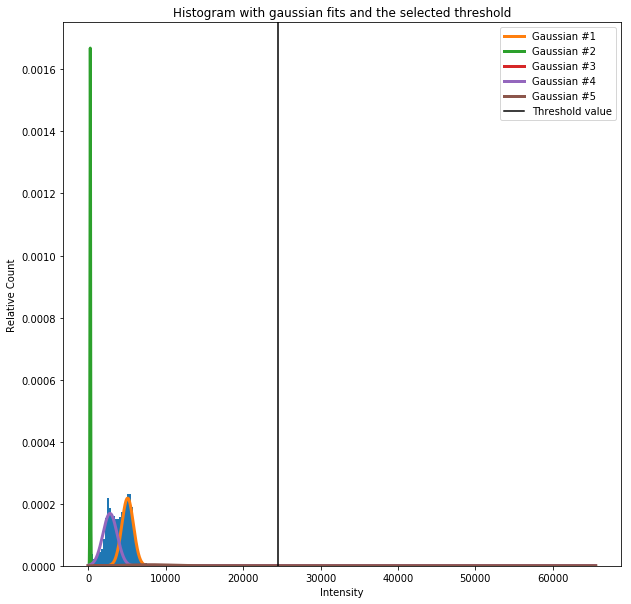

Precision: 0.809
Recall: 0.413


In [11]:
%reload_ext autoreload
%autoreload 2
from IPython.core.pylabtools import figsize
figsize(10, 10)

from tifffile import imread, imsave
from src.BlobDetector import BlobDetector
from src.BlobMetrics import BlobMetrics
from src import util
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from datetime import datetime

exp_name = 'cell_detection_9'

component_dict = {
    'cell_detection_0': 4,
    'cell_detection_1': 4,
    'cell_detection_2': 4,
    'cell_detection_3': 4,
    'cell_detection_4': 8,
    'cell_detection_5': 5,
    'cell_detection_6': 5,
    'cell_detection_7': 7,
    'cell_detection_8': 5,
    'cell_detection_9': 5
}

data_source = 'COLM' if int(exp_name.split('_')[2]) <= 3 else 'laVision'

input_tif_path = './data/s3617/tifs/{}.tiff'.format(exp_name)
img = imread(input_tif_path)

detector = BlobDetector(input_tif_path, n_components=component_dict[exp_name])
s1 = datetime.now()
centroids = detector.get_blob_centroids()
s2 = datetime.now()
print('time taken', (s2-s1))
print(detector.threshold)

gmm = detector.gmm
x = np.arange(0, img.max())
std_devs = np.sqrt(np.linalg.eigvals(gmm.covariances_).flatten())

gaussians = np.array([p * norm.pdf(x, mu, std_dev) for mu, std_dev, p in zip(gmm.means_.flatten(), std_devs, gmm.weights_)])

print(len(gaussians))
plt.hist(img.flatten(), bins=256, normed=True)

for i, gauss in enumerate(gaussians):
    plt.plot(x, gauss, linewidth=3.0, label='Gaussian #{}'.format(i+1))

plt.axvline(x=detector.threshold, color='k', label='Threshold value')
    
plt.title('Histogram with gaussian fits and the selected threshold')
plt.xlabel('Intensity')
plt.ylabel('Relative Count')
plt.legend()
plt.show()

ground_truth_path = 'data/s3617/annotations/{}.csv'.format(exp_name)
ground_truth = util.get_list_from_csv(ground_truth_path)

metrics = BlobMetrics(ground_truth, centroids, euclidean_distance_threshold=12)
print('Precision: {}\nRecall: {}'.format(metrics.precision(), metrics.recall()))
imsave('threshold_analysis_{}.tiff'.format(exp_name), detector.thresholded_img.astype(np.uint8))